# Libraries used:

numpy 1.19.5
<br>
tensorflow 2.4.1
<br>
pandas 1.2.4
<br>
matplotlib 3.3.4
<br>
tensorflow_addons 0.12.1 

In [1]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

In [2]:
tf.random.set_seed(1234)

# Data processing and augmentation

In [3]:
df=pd.read_csv('Train.csv')
df.head(14)

,Image_ID,class,xmin,ymin,width,height
0,ID_007FAIEI,fruit_woodiness,87.0,87.5,228.0,311.0
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,245.0,354.5
2,ID_00WROUT9,fruit_brownspot,156.5,209.5,248.0,302.5
3,ID_00ZJEEK3,fruit_healthy,125.0,193.0,254.5,217.0
4,ID_018UIENR,fruit_brownspot,79.5,232.5,233.5,182.0
5,ID_01QZDXVQ,fruit_woodiness,139.5,238.5,285.5,231.5
6,ID_02PX7GI8,fruit_brownspot,1.5,94.5,256.0,236.0
7,ID_02PX7GI8,fruit_brownspot,124.0,352.5,160.5,159.5
8,ID_03WE3EVQ,fruit_brownspot,168.0,95.5,340.0,202.5
9,ID_052XYWUM,fruit_woodiness,37.5,206.0,197.5,168.0


In [4]:
fnames=[]
classes=[]
bbox=[]
for i in range(len(df)):
    fnames.append('Train_Images\\{}.jpg'.format(df['Image_ID'][i]))
    
    label_name=df['class'][i]
    if label_name=='fruit_healthy':
        labels=np.array([1,0,0])
    if label_name=='fruit_woodiness':
        labels=np.array([0,1,0])
    if label_name=='fruit_brownspot':
        labels=np.array([0,0,1])
    classes.append(labels)    
    
    bbox_coordinates=np.array([df['xmin'][i]+0.5*df['width'][i],df['ymin'][i]+0.5*df['height'][i],
                               df['width'][i],df['height'][i]])
    bbox.append(bbox_coordinates.astype('float32'))
    

In [5]:
#add multiple bounding boxes to same image (placeholder for 5 bounding boxes)

fname_p=fnames[0]
multiple_classes=[classes[0]]
multiple_bbox=[bbox[0]]

fnames_sorted=[]
classes_sorted=[]
bbox_sorted=[]

for i in range(1,len(fnames)):
    fname_i=fnames[i]
    class_i=classes[i]
    bbox_i=bbox[i]
    if fname_i!=fname_p:
        while len(multiple_classes)!=5:
            multiple_classes.append(np.array([0,0,0]))
            multiple_bbox.append(np.array([0,0,1,1],dtype='float32'))
        fnames_sorted.append(fname_p)
        classes_sorted.append(multiple_classes)
        bbox_sorted.append(multiple_bbox)
        multiple_classes=[]
        multiple_bbox=[]
        fname_p=fname_i
        
    multiple_classes.append(class_i)
    multiple_bbox.append(bbox_i)
    

In [6]:
ds_size=len(fnames_sorted)

fnames_dataset = tf.data.Dataset.from_tensor_slices(fnames_sorted)
classes_dataset = tf.data.Dataset.from_tensor_slices(classes_sorted)
bbox_dataset = tf.data.Dataset.from_tensor_slices(bbox_sorted)

ds = tf.data.Dataset.zip((fnames_dataset, classes_dataset, bbox_dataset))

In [7]:
train_ratio = 0.80
ds_train1=ds.take(int(ds_size*train_ratio))
ds_test1=ds.skip(int(ds_size*train_ratio))

In [8]:
IMG_SIZE=512

def bbox_rotation(bbox,deg):
    bbox=bbox.numpy()
    #deg 1: 90, 2:180, 3: 270
    if deg==0:
        return tf.constant(bbox)
    if deg==3:
        return tf.constant([[512-bbox[0,1],bbox[0,0],bbox[0,3],bbox[0,2]],
                           [512-bbox[1,1],bbox[1,0],bbox[1,3],bbox[1,2]],
                           [512-bbox[2,1],bbox[2,0],bbox[2,3],bbox[2,2]],
                           [512-bbox[3,1],bbox[3,0],bbox[3,3],bbox[3,2]],
                           [512-bbox[4,1],bbox[4,0],bbox[4,3],bbox[4,2]]],dtype='float32')
    
    elif deg==2:
        return tf.constant([[512-bbox[0,0],512-bbox[0,1],bbox[0,2],bbox[0,3]],
                           [512-bbox[1,0],512-bbox[1,1],bbox[1,2],bbox[1,3]],
                           [512-bbox[2,0],512-bbox[2,1],bbox[2,2],bbox[2,3]],
                           [512-bbox[3,0],512-bbox[3,1],bbox[3,2],bbox[3,3]],
                           [512-bbox[4,0],512-bbox[4,1],bbox[4,2],bbox[4,3]]],dtype='float32')

    elif deg==1:
        return tf.constant([[bbox[0,1],512-bbox[0,0],bbox[0,3],bbox[0,2]],
                           [bbox[1,1],512-bbox[1,0],bbox[1,3],bbox[1,2]],
                           [bbox[2,1],512-bbox[2,0],bbox[2,3],bbox[2,2]],
                           [bbox[3,1],512-bbox[3,0],bbox[3,3],bbox[3,2]],
                           [bbox[4,1],512-bbox[4,0],bbox[4,3],bbox[4,2]]],dtype='float32')
    else:
        return NotImplemented
    
    
def process_img(img, deg):
    image = tf.io.read_file(img)
    image = tf.image.decode_jpeg(image, channels=3) 
    image = tf.image.convert_image_dtype(image, tf.float32) 
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image=tfa.image.rotate(image,tf.constant(np.pi*0.5*deg))
    return image

def read_images(fnames, classes, bbox, deg):
    img = process_img(fnames, deg)
    bbox=bbox_rotation(bbox,deg)
    return img, classes, bbox

In [9]:
ds_train=ds_train1.map(lambda img, classes, bbox: tf.py_function(func=read_images,
          inp=[img, classes, bbox, 0.], Tout=(tf.float32,tf.int32,tf.float32)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=True)

ds_test=ds_test1.map(lambda img, classes, bbox: tf.py_function(func=read_images,
          inp=[img, classes, bbox, 0.], Tout=(tf.float32,tf.int32,tf.float32)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=True)

# Anchors

In [10]:
width=np.array(df['width'][:])
height=np.array(df['height'][:])

height_width_ratio=height/width
area=height*width

std_weight_ar=1
std_weight_area=1.5

aspect_ratios=np.array([1/(1-std_weight_ar*np.std(height_width_ratio)),
                        1,
                       (1-std_weight_ar*np.std(height_width_ratio))])
areas=np.array([(np.mean(height)-std_weight_area*np.std(height))**2,
                np.mean(height)**2,
                       (np.mean(height)+std_weight_area*np.std(height))**2])

print('hw_ratio:')
print(aspect_ratios)
print('area:')
print(areas)

area_aspect_ratio_combination=[]
for area in areas:
    for aspect_ratio in aspect_ratios:
        area_aspect_ratio_combination.append(np.array([area,aspect_ratio]))
        
width_height_combination=[]
for area, aspect_ratio in area_aspect_ratio_combination:
    width=(area/aspect_ratio)**0.5
    height=area/width
    width_height_combination.append(np.array([width,height]))

        
#anchor_boxes=[x_centre,y_centre,width,height] 
#vgg output: 16x16, stride 32
stride=32
nr_seg=(int(IMG_SIZE/stride))

x_centres=np.arange(stride/2,IMG_SIZE,stride)
y_centres=np.arange(stride/2,IMG_SIZE,stride)
xx, yy = np.meshgrid(x_centres, y_centres, sparse=False, indexing='xy')

print('Anchors width-height combinations')
print(width_height_combination)

hw_ratio:
[1.68218021 1.         0.59446663]
area:
[10505.79826832 41160.3691945  91968.18773159]
Anchors width-height combinations
[array([ 79.02750468, 132.93850427]), array([102.49779641, 102.49779641]), array([132.93850427,  79.02750468]), array([156.42399425, 263.13334722]), array([202.88018433, 202.88018433]), array([263.13334722, 156.42399425]), array([233.82048383, 393.32819018]), array([303.26257226, 303.26257226]), array([393.32819018, 233.82048383])]


In [11]:
reg_anchors=np.zeros((nr_seg,nr_seg,9,4))
nr_anchors=nr_seg*nr_seg*9

for y_index in range(nr_seg):
    for x_index in range(nr_seg):
        for anchor_index in range(9):
            #x_centre
            reg_anchors[y_index,x_index,anchor_index,0]=xx[y_index,x_index]
            #y_centre
            reg_anchors[y_index,x_index,anchor_index,1]=yy[y_index,x_index]
            #width
            reg_anchors[y_index,x_index,anchor_index,2]=width_height_combination[anchor_index][0]
            #height
            reg_anchors[y_index,x_index,anchor_index,3]=width_height_combination[anchor_index][1]
            

x_a=reg_anchors[:, :, :, 0]
y_a=reg_anchors[:, :, :, 1]
w_a=reg_anchors[:, :, :, 2]
h_a=reg_anchors[:, :, :, 3]            

reg_anchors_tf_overlap=tf.convert_to_tensor(reg_anchors,dtype='float32')
reg_anchors_tf_overlap=tf.reshape(reg_anchors_tf_overlap, [nr_seg*nr_seg*9, 4])

training_anchors=np.ones((nr_seg,nr_seg,9))
#print(np.sum(training_anchors))
for y_index in range(nr_seg):
    for x_index in range(nr_seg):
        for anchor_index in range(9):
            #check for anchor boxes with boundaries outside

            if (x_a[y_index,x_index,anchor_index]-0.5*w_a[y_index,x_index,anchor_index]<0 or
                x_a[y_index,x_index,anchor_index]+0.5*w_a[y_index,x_index,anchor_index]>IMG_SIZE or
                y_a[y_index,x_index,anchor_index]-0.5*h_a[y_index,x_index,anchor_index]<0 or
                y_a[y_index,x_index,anchor_index]+0.5*h_a[y_index,x_index,anchor_index]>IMG_SIZE):
                training_anchors[y_index,x_index,anchor_index]=False
            else: 
                training_anchors[y_index,x_index,anchor_index]=True

training_anchors_tf=tf.convert_to_tensor(training_anchors)
training_anchors_tf=tf.reshape(training_anchors_tf, [nr_seg*nr_seg*9])

reg_anchors_tf=tf.boolean_mask(
    reg_anchors_tf_overlap, training_anchors_tf, axis=None, name='boolean_mask'
)

In [12]:
ds_train_final = ds_train.map(lambda a, b, c: (a, (b,c)))
ds_test_final = ds_test.map(lambda a, b, c: (a, (b,c)))

# Model building

In [13]:
@tf.function
def calc_reg_targets(bboxes):
    bboxes=tf.tile(tf.expand_dims(bboxes,axis=1),tf.stack([1,tf.shape(reg_anchors_tf)[0],1]))
    targets=[]
    
    t_x_star=(bboxes[:,:,0]-reg_anchors_tf[:,0])/reg_anchors_tf[:,2]
    t_y_star=(bboxes[:,:,1]-reg_anchors_tf[:,1])/reg_anchors_tf[:,3]
    t_w_star=tf.math.log(bboxes[:,:,2]/reg_anchors_tf[:,2])
    t_h_star=tf.math.log(bboxes[:,:,3]/reg_anchors_tf[:,3])

    target=tf.stack([t_x_star,t_y_star,t_w_star,t_h_star],axis=-1)

    return target

@tf.function
def IoU(inputs):
    anchor=inputs[:4]
    target=inputs[4:]
    gl = tfa.losses.GIoULoss(mode = 'iou')
    
    boxes1 = tf.stack([anchor[1]-0.5*anchor[3], anchor[0]-0.5*anchor[2], 
                          anchor[1]+0.5*anchor[3], anchor[0]+0.5*anchor[2]],axis=0)
    boxes2 = tf.stack([target[1]-0.5*target[3], target[0]-0.5*target[2], 
                          target[1]+0.5*target[3], target[0]+0.5*target[2]],axis=0)
    loss = gl(boxes1, boxes2)
    return 1-loss


@tf.function
def IoU_matrix(bboxes):
    bboxes_tile=tf.tile(bboxes,tf.stack([tf.shape(reg_anchors_tf)[0],1]))
    

    reg_anchors_tf_tile=tf.tile(reg_anchors_tf,tf.stack([tf.shape(bboxes)[0],1]))
    
    inputs=tf.concat([reg_anchors_tf_tile,bboxes_tile],axis=-1)
    
    ans=tf.map_fn(IoU, inputs) 
    
    ans_reshape=tf.reshape(ans,(tf.shape(bboxes)[0],tf.shape(reg_anchors_tf)[0]))
    
    return ans_reshape

@tf.function
def cls_score(IoU_matrix):
    score = tf.ones_like(IoU_matrix)*(-1)

    max_array = tf.tile(tf.expand_dims(tf.math.reduce_max(IoU_matrix, axis=1),axis=-1),
            tf.stack([1,tf.shape(IoU_matrix)[-1]]))

    score = tf.where(max_array==IoU_matrix,1.,score)
    IoU_matrix = tf.where(max_array==IoU_matrix,1.,IoU_matrix)
    

    score = tf.where(IoU_matrix>0.7, 1., score)  #0.8
    score = tf.where(IoU_matrix<0.1, 0., score)
    
    return score

@tf.function
def train_sampling(score,possible_targets,seed):
    positive_indexes=tf.where(score==1)
    negative_indexes=tf.where(score==0)
    
    nr_samples_positive=tf.math.minimum(tf.shape(positive_indexes)[0],128)
    
    idxs_p = tf.range(tf.shape(positive_indexes)[0])
    ridxs_p = tf.random.shuffle(idxs_p,seed=seed)[:nr_samples_positive]
    positive_indexes_sampled = tf.gather(positive_indexes, ridxs_p)
    
    idxs_n = tf.range(tf.shape(negative_indexes)[0])
    ridxs_n = tf.random.shuffle(idxs_n,seed=seed)[:nr_samples_positive]
    negative_indexes_sampled = tf.gather(negative_indexes, ridxs_n)
    
    positive_score=tf.gather_nd(score, positive_indexes_sampled)
    negative_score=tf.gather_nd(score, negative_indexes_sampled)
    
    final_score=tf.concat([positive_score,negative_score],axis=0)
    
    positive_targets=tf.gather_nd(possible_targets, positive_indexes_sampled)
    negative_targets=tf.gather_nd(possible_targets, negative_indexes_sampled)
    
    final_targets=tf.concat([positive_targets,negative_targets],axis=0)
    
    indexes_sampled=tf.concat([positive_indexes_sampled,negative_indexes_sampled],axis=0)
    
    return final_score, final_targets,indexes_sampled[:,1]

@tf.function
def smooth_L1(x):
    ans=tf.where(tf.abs(x)<1,0.5*x**2,tf.abs(x)-0.5)
    return tf.reduce_sum(ans)
        

@tf.function
def RPN_training_loss(score_pred,target_pred, final_score, final_targets, indexes_sampled):
    positive_indexes=tf.where(final_score==1)
    
    number_of_targets=tf.cast(tf.shape(final_targets)[-2], dtype='int32')
    
    final_score_2=tf.expand_dims(final_score,axis=-1)
    final_score_2=tf.concat([final_score_2,1-final_score_2],axis=1)
    
    indexes_sampled_output=tf.gather(tf.where(training_anchors_tf),indexes_sampled, axis=-2)
    indexes_sampled_output=tf.squeeze(indexes_sampled_output, axis=-1)

    
    score_pred=tf.gather(score_pred,indexes_sampled_output, axis=-2)
    target_pred=tf.gather(target_pred,indexes_sampled_output, axis=-2)
    
    score_pred=tf.squeeze(score_pred,axis=0)
    target_pred=tf.squeeze(target_pred,axis=0)
    
    cce = tf.keras.losses.CategoricalCrossentropy()
    class_loss_mean=cce(final_score_2, score_pred)
    
    reg_loss_total=tf.reduce_sum(tf.math.multiply(final_score,
                                            tf.map_fn(smooth_L1, (target_pred-final_targets))))
    
    
    reg_loss_mean=tf.divide(reg_loss_total,tf.cast(number_of_targets, dtype='float32'))
    
    return (class_loss_mean+reg_loss_mean)*tf.cast(number_of_targets, dtype='float32')


@tf.function
def calc_reg_targets_single_prop(bbox,bbox_prop):
    
    t_x_star=(bbox[0]-bbox_prop[0])/bbox_prop[2]
    t_y_star=(bbox[1]-bbox_prop[1])/bbox_prop[3]
    t_w_star=tf.math.log(bbox[2]/bbox_prop[2])
    t_h_star=tf.math.log(bbox[3]/bbox_prop[3])

    target=tf.stack([t_x_star,t_y_star,t_w_star,t_h_star],axis=-1)

    return target


@tf.function
def distorted_bbox(bbox,scale=1):
    random_val=tf.random.normal([4], 0, 1, tf.float32, seed=1)
    
    x_offset=0.16*random_val[0]*scale 
    y_offset=0.16*random_val[1]*scale 

    w_scale=(1.3)**(random_val[2]*scale)
    h_scale=(1.3)**(random_val[3]*scale)
    
    dist_bbox=tf.stack([bbox[0]+x_offset*bbox[2],bbox[1]+y_offset*bbox[2],
                        bbox[2]*w_scale,bbox[3]*h_scale],axis=-1)
    
    dist_bbox_x_y=tf.stack([dist_bbox[0]-0.5*dist_bbox[2],dist_bbox[1]-0.5*dist_bbox[3],
                             dist_bbox[0]+0.5*dist_bbox[2],dist_bbox[1]+0.5*dist_bbox[3]],axis=-1)
    
    def c1(): return bbox
    def c2(): return dist_bbox
   
    dist_bbox_final=tf.case([(tf.less(dist_bbox_x_y[0],0), c1), (tf.less(dist_bbox_x_y[1],0), c1),
                             (tf.greater(dist_bbox_x_y[2],512), c1),
                             (tf.greater(dist_bbox_x_y[3],512), c1)],
         default=c2)

    IoU1=IoU(tf.concat([dist_bbox_final,bbox],axis=-1)) 
    
    return dist_bbox_final, IoU1
    

        
@tf.function
def CN_training_loss(iou_pred, class_pred, target_pred, IoU_t, class_t, target_t):
    
    cce = tf.keras.losses.CategoricalCrossentropy()
    class_loss=cce(class_t, tf.squeeze(class_pred,axis=0))
    
    mse = tf.keras.losses.MeanSquaredError()
    iou_mse=mse(IoU_t, iou_pred)
    
    reg_loss=smooth_L1(target_pred-target_t)
    
    return class_loss+iou_mse+reg_loss


@tf.function
def BGCN_training_loss(class_pred, class_t):
    
    cce = tf.keras.losses.CategoricalCrossentropy()
    class_loss=cce(class_t, class_pred)
    
    return class_loss

#@tf.function
def bounding_box_crop(bbox):
    #bbox input: [xc,yc,w,h]
    if tf.shape(tf.shape(bbox))==2:
        #bbox_x_y: [xmin,ymin,xmax,ymax]
        bbox_x_y=tf.stack([bbox[:,0]-0.5*bbox[:,2],bbox[:,1]-0.5*bbox[:,3],
                             bbox[:,0]+0.5*bbox[:,2],bbox[:,1]+0.5*bbox[:,3]],axis=-1)
        bbox_x_y=tf.where(tf.less(bbox_x_y,0.),0.,bbox_x_y)
        bbox_x_y=tf.where(tf.greater(bbox_x_y,512.),512.,bbox_x_y)
        
        bbox_new=tf.stack([(bbox_x_y[:,0]+bbox_x_y[:,2])/2,(bbox_x_y[:,1]+bbox_x_y[:,3])/2,
                             (bbox_x_y[:,2]-bbox_x_y[:,0]),(bbox_x_y[:,3]-bbox_x_y[:,1])],axis=-1)
        return bbox_new
    
    else:# tf.shape(tf.shape(bbox))==1:  
        bbox_x_y=tf.stack([bbox[0]-0.5*bbox[2],bbox[1]-0.5*bbox[3],
                             bbox[0]+0.5*bbox[2],bbox[1]+0.5*bbox[3]],axis=-1)
        bbox_x_y=tf.where(tf.less(bbox_x_y,0.),0.,bbox_x_y)
        bbox_x_y=tf.where(tf.greater(bbox_x_y,512.),512.,bbox_x_y)
        bbox_new=tf.stack([(bbox_x_y[0]+bbox_x_y[2])/2,(bbox_x_y[1]+bbox_x_y[3])/2,
                             (bbox_x_y[2]-bbox_x_y[0]),(bbox_x_y[3]-bbox_x_y[1])],axis=-1)
        return bbox_new
            

# Region Proposal Network

In [14]:
class RPN(tf.keras.models.Model):
    def __init__(self):
        super(RPN, self).__init__()
                 

        self.base_model = tf.keras.applications.VGG16(
                weights='imagenet',  
                input_shape=(IMG_SIZE, IMG_SIZE, 3),
                include_top=False)  
        
        for i in range(14):
            self.base_model.layers[i].trainable=False
        
        self.conv1=tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same')

        self.box_reg=tf.keras.layers.Conv2D(36, (1,1), activation='relu')
        self.box_reg_reshape=tf.keras.layers.Reshape((nr_seg, nr_seg, 9, 4))

        self.box_cls=tf.keras.layers.Conv2D(18, (1,1), activation='relu')
        self.box_cls_reshape=tf.keras.layers.Reshape((nr_seg, nr_seg, 9, 2))

        self.concat1=tf.keras.layers.Concatenate(axis=-1)
        self.reshape_final=tf.keras.layers.Reshape((nr_seg*nr_seg*9, 6))
        
        

        
    def call(self, image):
        image = tf.reshape(image, (1, tf.shape(image)[-3], tf.shape(image)[-2], tf.shape(image)[-1])) #Line 4
        image=tf.reverse(image, axis=[-1])
        image=tf.image.per_image_standardization(image)
        
        x = self.base_model(image, training=False)
        conv1= self.conv1(x)
        
        box_reg1=self.box_reg(conv1)
        box_reg_reshape1=self.box_reg_reshape(box_reg1)
        
        box_cls1=self.box_cls(conv1)
        box_cls_reshape1=self.box_cls_reshape(box_cls1)
        box_cls_reshape1_softmax=tf.keras.activations.softmax(box_cls_reshape1)
        
        concat1=self.concat1([box_cls_reshape1_softmax, box_reg_reshape1])
        reshape1=self.reshape_final(concat1)
        
        return reshape1

    
    #@tf.function
    def train_step(self, data):
        
        inputs= data[0]
        targets= data[1]
        
        classes=targets[0]
        bbox=targets[1]
        number_of_bbox=tf.reduce_sum(classes)
        number_of_bbox=tf.cast(number_of_bbox, dtype='int32')
        
        classes=classes[:number_of_bbox,:]
        bbox=bbox[:number_of_bbox,:]
        
        possible_targets1=calc_reg_targets(bbox)
        
        IoU_matrix1=IoU_matrix(bbox)
        
        score1=cls_score(IoU_matrix1)
        
        final_score1, final_targets1, indexes_sampled1=train_sampling(score1,possible_targets1,seed=0)

        with tf.GradientTape() as tape:
            y_pred = self(inputs)
            score_pred1, target_pred1 = tf.split(y_pred, [2, 4], -1)
            
            loss_value = RPN_training_loss(score_pred1, target_pred1, 
                                           final_score1, final_targets1, indexes_sampled1)
            
            

        grads = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        
        return {"loss_value": loss_value}
    
    @tf.function
    def bbox_predictions(self, inputs):
        y_pred = self(inputs)
        #indexes_sampled_output=tf.squeeze(tf.where(training_anchors_tf),axis=-1)
        
        #y_pred = tf.gather(y_pred,indexes_sampled_output, axis=-2)

        
        score_pred1, target_pred1 = tf.split(y_pred, [2, 4], -1)
        
        scores=score_pred1[:,:,0]
        
        
        t_x=target_pred1[:,:,0]
        t_y=target_pred1[:,:,1]
        t_w=target_pred1[:,:,2]
        t_h=target_pred1[:,:,3]
        
        x=t_x*reg_anchors_tf_overlap[:,2]+reg_anchors_tf_overlap[:,0]
        y=t_y*reg_anchors_tf_overlap[:,3]+reg_anchors_tf_overlap[:,1]
        w=tf.math.exp(t_w)*reg_anchors_tf_overlap[:,2]
        h=tf.math.exp(t_h)*reg_anchors_tf_overlap[:,3]
        
        bbox_pred=tf.stack([x,y,w,h], axis=-1)
        bbox_non_max_suppression=tf.stack([y-0.5*h,x-0.5*w,y+0.5*h,x+0.5*w], axis=-1)#[y1,x1,y2,x2]
        
        sorted_indexes=tf.argsort(tf.squeeze(scores,axis=0), axis=-1, direction='DESCENDING')
        
        bbox_pred_sorted=tf.gather(bbox_pred,sorted_indexes, axis=-2)
        scores_sorted=tf.gather(scores,sorted_indexes, axis=-1)
        bbox_non_max_suppression_sorted=tf.gather(bbox_non_max_suppression,sorted_indexes, axis=-2)
        
        bbox_pred_sorted=tf.squeeze(bbox_pred_sorted,axis=0)
        scores_sorted=tf.squeeze(scores_sorted,axis=0)
        bbox_non_max_suppression_sorted=tf.squeeze(bbox_non_max_suppression_sorted,axis=0)
        
        final_indexes=tf.image.non_max_suppression(
            bbox_non_max_suppression_sorted, scores_sorted, max_output_size=10, iou_threshold=0.3,
            score_threshold=0.4
        )
        
        bbox_pred_final=tf.gather(bbox_pred_sorted,final_indexes, axis=-2)
        scores_final=tf.gather(scores_sorted,final_indexes, axis=-1)
        
        return scores_final, bounding_box_crop(bbox_pred_final)
        

# Classifier Network

In [15]:
base_model = tf.keras.applications.VGG16(
                weights='imagenet', 
                input_shape=(64, 64, 3), 
                include_top=False)

conv1=tf.keras.layers.Conv2D(512, (3,3), activation='relu',padding='same')(base_model.layers[-6].output)

flatten1=tf.keras.layers.Flatten()(conv1)
bn1=tf.keras.layers.BatchNormalization()(flatten1)
dense1=tf.keras.layers.Dense(1024, activation='relu')(bn1)
bn2=tf.keras.layers.BatchNormalization()(dense1)
dense2=tf.keras.layers.Dense(512, activation='relu')(bn2)
      
box_reg=tf.keras.layers.Dense(4, activation=None)(dense2)
iou_layer=tf.keras.layers.Dense(1, activation='sigmoid')(dense2)

box_cls=tf.keras.layers.Dense(3, activation='softmax')(dense2)
        
      
concat1=tf.keras.layers.Concatenate(axis=-1)([iou_layer,box_cls,box_reg])

cn_model=tf.keras.models.Model(inputs=base_model.inputs, outputs=concat1)
        

In [16]:
class CN(tf.keras.models.Model):
    def __init__(self):
        super(CN, self).__init__()
                
        self.base_model = cn_model  
        for i in range(14):
            self.base_model.layers[i].trainable=False
        
        self.distortion_scale=1
        
    def call(self, image):
        image = tf.reshape(image, (1, tf.shape(image)[-3], tf.shape(image)[-2], tf.shape(image)[-1])) #Line 4
        image=tf.reverse(image, axis=[-1])
        image=tf.image.per_image_standardization(image)
        
        x = self.base_model(image, training=False)
        
        
        return x
    
    
    @tf.function
    def bbox_prediction(self, img, bbox_dist):
        bbox_dist_cropped_coordinates=tf.stack([bbox_dist[1]-0.5*bbox_dist[3], 
                                                bbox_dist[0]-0.5*bbox_dist[2], 
                          bbox_dist[1]+0.5*bbox_dist[3], bbox_dist[0]+0.5*bbox_dist[2]],
                                               axis=-1)/512
        
        img_cropped=tf.image.crop_and_resize(
            tf.expand_dims(img,axis=0), tf.expand_dims(bbox_dist_cropped_coordinates,axis=0), 
            box_indices=tf.constant([0]), crop_size=[64,64]) 
        
        y_pred = self(img_cropped)
        iou_pred1, class_pred1, target_pred1 = tf.split(y_pred, [1, 3, 4], -1)
        
        t_x=target_pred1[:,0]
        t_y=target_pred1[:,1]
        t_w=target_pred1[:,2]
        t_h=target_pred1[:,3]
        
        x=t_x*bbox_dist[2]+bbox_dist[0]
        y=t_y*bbox_dist[3]+bbox_dist[1]
        w=tf.math.exp(t_w)*bbox_dist[2]
        h=tf.math.exp(t_h)*bbox_dist[3]
        
        bbox_pred=tf.stack([x,y,w,h], axis=-1)
        
        return tf.squeeze(iou_pred1,axis=0), tf.squeeze(class_pred1,axis=0), tf.squeeze(bbox_pred,axis=0)
        

    
    #@tf.function
    def train_step(self, data):
        
        inputs= data[0]
        targets= data[1]
        
        classes=targets[0]
        bbox=targets[1]
        
        #sample distorted bbox, calculate IoU between real bbox and distorted bbox
        bbox_dist, IoU_dist_bbox=distorted_bbox(bbox,scale=self.distortion_scale)
        
        bbox_dist_cropped_coordinates=tf.stack([bbox_dist[1]-0.5*bbox_dist[3], 
                                                bbox_dist[0]-0.5*bbox_dist[2], 
                          bbox_dist[1]+0.5*bbox_dist[3], bbox_dist[0]+0.5*bbox_dist[2]],axis=0)/512
        
        img_cropped=tf.image.crop_and_resize(
            tf.expand_dims(inputs,axis=0), tf.expand_dims(bbox_dist_cropped_coordinates,axis=0), 
            box_indices=tf.constant([0]), crop_size=[64,64])
        
        
        
        
        reg_target=calc_reg_targets_single_prop(bbox,bbox_dist)
        
        with tf.GradientTape() as tape:
            y_pred = self(img_cropped)
            iou_pred1, class_pred1, target_pred1 = tf.split(y_pred, [1, 3, 4], -1)
            
            loss_value = CN_training_loss(iou_pred1, class_pred1, target_pred1,
                                           IoU_dist_bbox, classes, reg_target)
            
            

        grads = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(classes, class_pred1)

        return {m.name: m.result() for m in self.metrics} #{"loss_value": loss_value, 
    

# Background Classifier Network

In [17]:
base_model_bg = tf.keras.applications.VGG16(
                weights='imagenet', 
                input_shape=(64, 64, 3), 
                include_top=False)



flatten1_bg=tf.keras.layers.Flatten()(base_model_bg.output)
dense1_bg=tf.keras.layers.Dense(1024, activation='relu')(flatten1_bg)
bn2_bg=tf.keras.layers.BatchNormalization()(dense1_bg)
dense2_bg=tf.keras.layers.Dense(512, activation='relu')(bn2_bg)
       
box_cls_bg=tf.keras.layers.Dense(2, activation='softmax')(dense2_bg)

bgcn_model=tf.keras.models.Model(inputs=base_model_bg.inputs, outputs=box_cls_bg)

In [18]:
class BGCN(tf.keras.models.Model):
    def __init__(self):
        super(BGCN, self).__init__()
                 

        self.base_model = bgcn_model 
        
        #self.base_model.trainable=False
            
        for i in range(14):
            self.base_model.layers[i].trainable=False

    def call(self, image):
        image=tf.reverse(image, axis=[-1])
        image=tf.image.per_image_standardization(image)
        
        x = self.base_model(image, training=False)
        
        return x
    
    @tf.function
    def prediction(self, image_input, bbox):
        bbox_cropped_coordinates=tf.stack([bbox[:,1]-0.5*bbox[:,3], 
                                                bbox[:,0]-0.5*bbox[:,2], 
                          bbox[:,1]+0.5*bbox[:,3], bbox[:,0]
                                                +0.5*bbox[:,2]],axis=-1)/512
        
        img_cropped=tf.image.crop_and_resize(
            image_input, bbox_cropped_coordinates, 
            box_indices=tf.range(0, tf.shape(bbox)[0], 1), crop_size=[64,64])
        
        
        image=tf.reverse(img_cropped, axis=[-1])
        image=tf.image.per_image_standardization(image)
        
        x = self.base_model(image, training=False)
        
        return x
    
    #@tf.function
    def train_step(self, data):
        
        inputs= data[0]
        targets= data[1]
        
        classes=targets[0]
        bbox=targets[1]
        
        bbox_cropped_coordinates=tf.stack([bbox[:,1]-0.5*bbox[:,3], 
                                                bbox[:,0]-0.5*bbox[:,2], 
                          bbox[:,1]+0.5*bbox[:,3], bbox[:,0]
                                                +0.5*bbox[:,2]],axis=-1)/512
        
        img_cropped=tf.image.crop_and_resize(
            inputs, bbox_cropped_coordinates, 
            box_indices=tf.range(0, tf.shape(bbox)[0], 1), crop_size=[64,64])
        
        
        with tf.GradientTape() as tape:
            class_pred1 = self(img_cropped)
            
            loss_value = BGCN_training_loss(class_pred1, classes)
        
        grads = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(classes, class_pred1)
       
        return {m.name: m.result() for m in self.metrics}#{'loss_value': loss_value} 
    
    
    def test_step(self, data):
        inputs= data[0]
        targets= data[1]
        
        classes=targets[0]
        bbox=targets[1]
        
        bbox_cropped_coordinates=tf.stack([bbox[:,1]-0.5*bbox[:,3], 
                                                bbox[:,0]-0.5*bbox[:,2], 
                          bbox[:,1]+0.5*bbox[:,3], bbox[:,0]
                                                +0.5*bbox[:,2]],axis=-1)/512
        
        img_cropped=tf.image.crop_and_resize(
            inputs, bbox_cropped_coordinates, 
            box_indices=tf.range(0, tf.shape(bbox)[0], 1), crop_size=[64,64])
        
        
        class_pred1 = self(img_cropped)
        
        self.compiled_metrics.update_state(classes, class_pred1)
        
        return {m.name: m.result() for m in self.metrics}

## Load weights

In [19]:
rpn1=RPN()
rpn1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=None)

rpn1.load_weights('./checkpoints/RPN_9600_mini_batches_adam_0.0001_trainable_vgg')


cn1=CN()
cn1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=None,
           metrics=[tf.keras.metrics.CategoricalAccuracy()])

cn1.load_weights('./checkpoints/CN_9600_mini_batches_adam_0.0001_DS2_40epochs_no_background')

bgcn1=BGCN()
bgcn1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=None,
           metrics=[tf.keras.metrics.CategoricalAccuracy()])

bgcn1.load_weights('./checkpoints/BGCN_9600_mini_batches_adam_0.0001_1epoch_trainable_vgg') 


# RPN, CN and BGCN combined

In [20]:
def Faster_RCNN(image, visualize=False, fname=None):
    #make bbox predictions
    score, bbox_predictions=rpn1.bbox_predictions(image)
    
    if score.shape[-1]==0:
        return np.array([[fname.numpy(),'fruit_healthy',0.5,171.,171.,341.,341.]])
    
    bbox_predictions=bounding_box_crop(bbox_predictions)
     
    class_final=[]
    bbox_final=[]
    iou_final=[]
    iou_imp=[]
    
    for i in range(score.shape[0]):
        bbox=bbox_predictions[i,:]
        
        iou_pred1, class_pred1, bbox_updated1= cn1.bbox_prediction(image, bbox)
        bbox_updated1=bounding_box_crop(bbox_updated1)
        
        for k in range(3):
            iou_pred1, class_pred1, bbox_updated1= cn1.bbox_prediction(image, bbox_updated1)
            bbox_updated1=bounding_box_crop(bbox_updated1)
            
        prediction=bgcn1.prediction(tf.expand_dims(image,axis=0), tf.expand_dims(bbox_updated1,axis=0))
        
        if prediction[0,0]>0.34:
            iou_final.append(iou_pred1)
            class_final.append(class_pred1)
            bbox_final.append(bbox_updated1)
            
    
    class_final1=tf.stack(class_final)
    bbox_final1=tf.stack(bbox_final)
    iou_final1=tf.stack(iou_final)
    
    if iou_final1.shape[-1]==0:
        return np.array([[fname.numpy(),'fruit_healthy',0.5,171.,171.,341.,341.]])
    
    scores=tf.math.reduce_max(class_final1, axis=-1)
    
    class_labels=tf.math.argmax(class_final1, axis=-1, output_type=tf.dtypes.int64)
    
    bbox_non_max_suppression=tf.stack(
        [bbox_final1[:,1]-0.5*bbox_final1[:,3],bbox_final1[:,0]-0.5*bbox_final1[:,2],
         bbox_final1[:,1]+0.5*bbox_final1[:,3],bbox_final1[:,0]+0.5*bbox_final1[:,2]], axis=-1)#[y1,x1,y2,x2]
        
    sorted_indexes=tf.argsort(scores, axis=-1, direction='DESCENDING')

    bbox_final1_sorted=tf.gather(bbox_final1,sorted_indexes, axis=-2)
    class_labels_sorted=tf.gather(class_labels,sorted_indexes, axis=-1)
    
    scores_sorted=tf.gather(scores,sorted_indexes, axis=-1)
    bbox_non_max_suppression_sorted=tf.gather(bbox_non_max_suppression,sorted_indexes, axis=-2)

    final_indexes=tf.image.non_max_suppression(
        bbox_non_max_suppression_sorted, scores_sorted, max_output_size=4, iou_threshold=0.3,
        score_threshold=0.5
    )

    bbox_output=tf.gather(bbox_non_max_suppression_sorted,final_indexes, axis=-2)
    scores_output=tf.gather(scores_sorted,final_indexes, axis=-1)
    class_labels_output=tf.gather(class_labels_sorted,final_indexes, axis=-1)

    
    if visualize:
        plt.figure()
        plt.imshow(np.squeeze(image.numpy()))
        
        for i in range(score.shape[0]):
            bbox_x=[bbox_predictions[i,0]-0.5*bbox_predictions[i,2],
                    bbox_predictions[i,0]+0.5*bbox_predictions[i,2],
                    bbox_predictions[i,0]+0.5*bbox_predictions[i,2],
                    bbox_predictions[i,0]-0.5*bbox_predictions[i,2],
                   bbox_predictions[i,0]-0.5*bbox_predictions[i,2]]
            bbox_y=[bbox_predictions[i,1]-0.5*bbox_predictions[i,3],
                    bbox_predictions[i,1]-0.5*bbox_predictions[i,3],
                    bbox_predictions[i,1]+0.5*bbox_predictions[i,3],
                    bbox_predictions[i,1]+0.5*bbox_predictions[i,3],
                   bbox_predictions[i,1]-0.5*bbox_predictions[i,3]]
            plt.plot(bbox_x,bbox_y,'g-',linewidth=2.5)
        
        
        for i in range(len(iou_final)):
            bbox_x=[bbox_final1[i,0]-0.5*bbox_final1[i,2],bbox_final1[i,0]+0.5*bbox_final1[i,2],
                    bbox_final1[i,0]+0.5*bbox_final1[i,2],bbox_final1[i,0]-0.5*bbox_final1[i,2],
                   bbox_final1[i,0]-0.5*bbox_final1[i,2]]
            bbox_y=[bbox_final1[i,1]-0.5*bbox_final1[i,3],bbox_final1[i,1]-0.5*bbox_final1[i,3],
                    bbox_final1[i,1]+0.5*bbox_final1[i,3],bbox_final1[i,1]+0.5*bbox_final1[i,3],
                   bbox_final1[i,1]-0.5*bbox_final1[i,3]]
            plt.plot(bbox_x,bbox_y,'r-',linewidth=3.5)
            
    scores_output=scores_output.numpy()
    class_labels_output=class_labels_output.numpy()
    bbox_output=bbox_output.numpy()
    
    if scores_output.shape[-1]==0:
        return np.array([[fname.numpy(),'fruit_healthy',0.5,171.,171.,341.,341.]])
    
    class_labels_string=[]
    fname_output=[]
    
    for label_value in class_labels_output:
        fname_output.append(fname.numpy())
        if label_value==0:
            class_labels_string.append('fruit_healthy')
        elif label_value==1:
            class_labels_string.append('fruit_woodiness')
        else:
            class_labels_string.append('fruit_brownspot')
            
    output=np.hstack((np.expand_dims(np.array(fname_output),axis=-1),
                      np.expand_dims(np.array(class_labels_string),axis=-1),
                      np.expand_dims(scores_output,axis=-1),bbox_output))
        
    return output
            

In [21]:
def visualize_output(image, output):
    
    plt.figure()
    fig= plt.imshow(np.squeeze(image.numpy()))

    for i in range(np.shape(output)[0]):
        bbox_x=[output[i,4],output[i,6],output[i,6],output[i,4],output[i,4]]
        bbox_y=[output[i,3],output[i,3],output[i,5],output[i,5],output[i,3]]
        
        bbox_x_float=[float(i) for i in bbox_x]
        bbox_y_float=[float(i) for i in bbox_y]
        plt.plot(bbox_x_float,bbox_y_float,linewidth=2.5, 
                 label='class:{}, confidence:{}'.format(output[i,1],output[i,2]))
    plt.legend(bbox_to_anchor=(0,1),loc='lower left')   
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

## Generalization set predictions

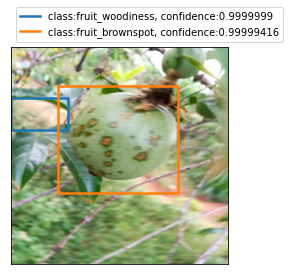

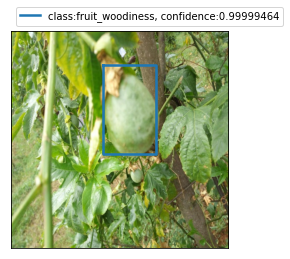

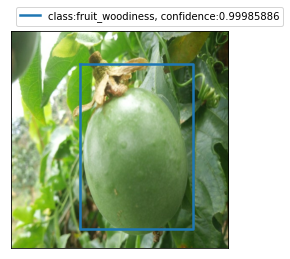

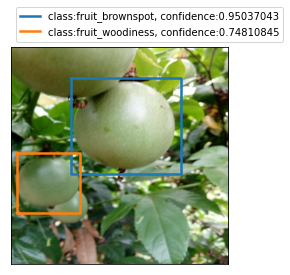

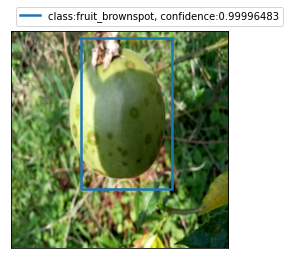

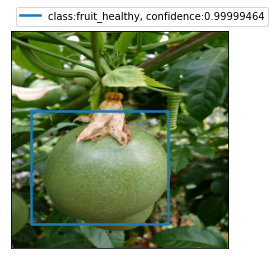

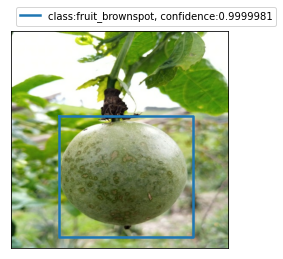

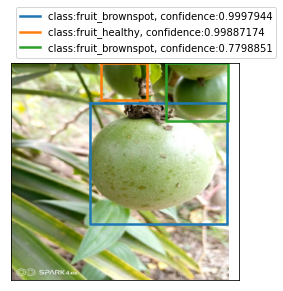

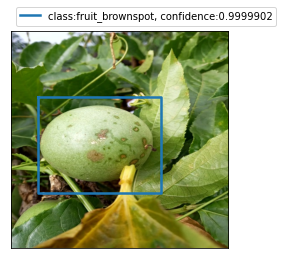

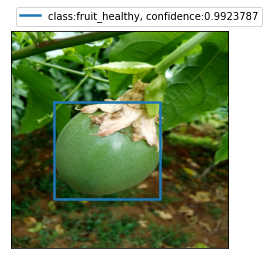

In [22]:
test_data=ds_test_final.take(10)
for image, target in test_data:
    
    output=Faster_RCNN(image,visualize=False,fname=tf.constant('name1'))
    visualize_output(image, output)
    plt.savefig('Classifier_cls_6', bbox_inches='tight')

In [23]:
df_test=pd.read_csv('Test.csv')
df_test.head(14)

fnames_test=[]
Image_ID_test=[]
for i in range(len(df_test)):
    fnames_test.append('Test_Images\\{}.jpg'.format(df_test['Image_ID'][i]))
    Image_ID_test.append(df_test['Image_ID'][i])

fnames_test_dataset = tf.data.Dataset.from_tensor_slices(fnames_test)
Image_ID_test_dataset = tf.data.Dataset.from_tensor_slices(Image_ID_test)

ds_eval = tf.data.Dataset.zip((fnames_test_dataset, Image_ID_test_dataset))    

In [24]:
def read_images_eval(fnames, ID):
    img = process_img(fnames, deg=0)
    return img, ID

ds_eval1=ds_eval.map(lambda img, ID: tf.py_function(func=read_images_eval,
          inp=[img, ID], Tout=(tf.float32,tf.string)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=True)

## Test set predictions

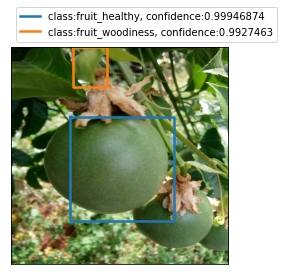

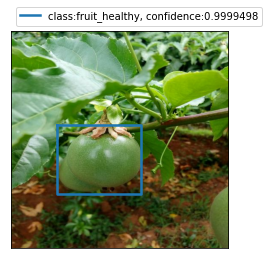

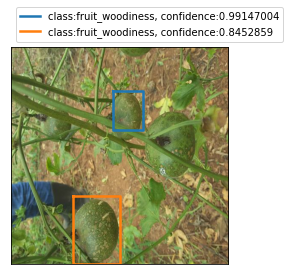

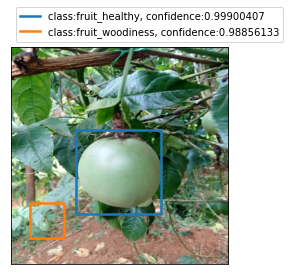

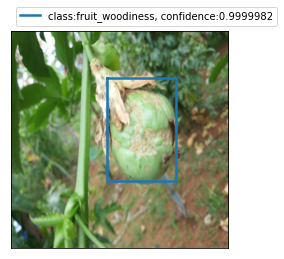

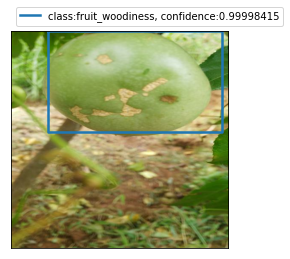

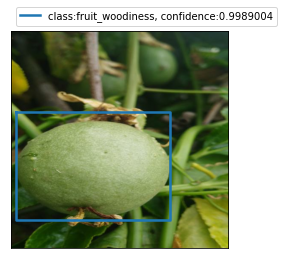

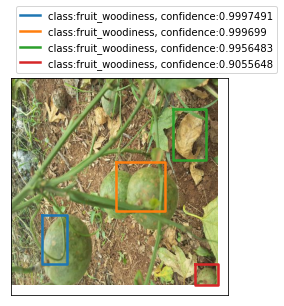

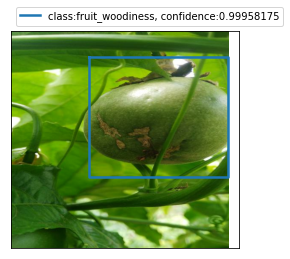

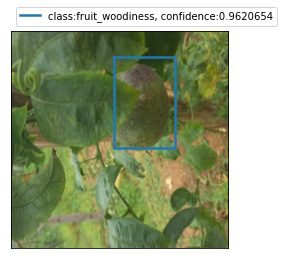

In [25]:
for image, ID in ds_eval1.take(10):
    output=Faster_RCNN(image,visualize=False,fname=tf.constant('name1'))
    visualize_output(image, output)

# Classify test set:
Uncomment the following cell to save the predictions to a csv file

In [26]:
# output_list=[]
# count=0
# for image, ID in ds_eval1:
#     output=Faster_RCNN(image,visualize=False,fname=ID)
#     output_list.append(output)
#     count=count+1
#     print(count)
    

# output_list_array=np.vstack(output_list)
# final_answer=output_list_array

# pd.DataFrame(final_answer).to_csv("Predictions1.csv",index=False,
#                                   header=['Image_ID','class','confidence','ymin','xmin','ymax','xmax'])

In [27]:
# answer=pd.read_csv("Predictions1.csv")
# answer.head(5)